In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

import scipy.stats
from sklearn.metrics import mean_squared_error

from sklearn.utils import resample

folder_figures = 'figures'

def perf_metrix(predictions: list, true_values: list):
    '''Compute various prediction performances metrics.'''
    
    pearson, pearson_p = scipy.stats.pearsonr(predictions, true_values)
    spearman, spearman_p = scipy.stats.spearmanr(predictions, true_values)
    rmse = np.sqrt(mean_squared_error(predictions, true_values))
    
    pearson = float("{0:.3g}".format(pearson))
    pearson_p = float("{0:.3g}".format(pearson_p))
    spearman = float("{0:.3g}".format(spearman))
    spearman_p = float("{0:.3g}".format(spearman_p))
    rmse = float("{0:.3g}".format(rmse))
    std_ratio = float("{0:.3g}".format(np.std(predictions)/np.std(true_values)))
    
    return pearson, pearson_p, spearman, spearman_p, rmse, std_ratio



In [3]:
# Code below not fully filled in; to be run with the right inputs
# Set up df_to_plot
# Insert csv file paths for saved predictions and errors
fp_database = "data/database_640.pkl"
fp_pred = "data/predictions_exp_blosum_640_mae_no_mean/ens_no_mean_spearman_div_emb.csv"

df_embed = pd.read_pickle(fp_database)
df_pred = pd.read_csv(fp_pred)
print(df_embed.columns)
# Insert here to extract predictions and errors here
predictions = [np.mean([float(p) for p in pred.split('_')]) for pred in df_pred[f"ridge_tm_4"].to_list()]

all_pred = predictions
all_true = df_embed['tm']

Index(['id', 'al_seq', 'seq', 'esm1b', 'esm2_t30', 'ablang', 'vhse',
       'antiberty', 'onehot', 'nanobuilder', 'nanobert', 'exp_method', 'tm',
       'clust_kmedoids_blosum', 'expmeth_clust_kmedoids_blosum',
       'clust_kmeans_esm1b', 'expmeth_clust_kmeans_esm1b'],
      dtype='object')


In [4]:
# Bootstrapping
subset_sizes = [0.02,0.1,0.2,0.33,0.5,0.75]
n_bootstraps = 10000
performance_distributions = {}

for size in subset_sizes:
    performance_metrics = []
    subset_size = int(size * len(all_pred))

    for _ in range(n_bootstraps):
        # Create a bootstrapped sample of the given size
        pred_resampled, true_resampled = resample(all_pred, all_true, n_samples=subset_size, replace=True)

        # Evaluate model
        perf_metrics = perf_metrix(pred_resampled, true_resampled)
        performance_metrics.append(perf_metrics)
    
    performance_distributions[size] = (performance_metrics)


0.02  median  0.8365
0.02  mean  0.8065621599999999
0.02  quantile 0.25  0.743
0.02  quantile 0.75  0.902
0.02  lower whisk  0.5045
0.1  median  0.843
0.1  mean  0.8374817999999999
0.1  quantile 0.25  0.809
0.1  quantile 0.75  0.871
0.1  lower whisk  0.7160000000000002
0.2  median  0.844
0.2  mean  0.8410656999999999
0.2  quantile 0.25  0.821
0.2  quantile 0.75  0.865
0.2  lower whisk  0.7549999999999999
0.33  median  0.844
0.33  mean  0.8424997
0.33  quantile 0.25  0.827
0.33  quantile 0.75  0.86
0.33  lower whisk  0.7774999999999999
0.5  median  0.844
0.5  mean  0.8435029
0.5  quantile 0.25  0.831
0.5  quantile 0.75  0.858
0.5  lower whisk  0.7905
0.75  median  0.844
0.75  mean  0.8438494999999999
0.75  quantile 0.25  0.833
0.75  quantile 0.75  0.855
0.75  lower whisk  0.7999999999999999


/var/folders/hr/1j50v5r91sv8fs_r8qhx8bym0000gn/T/ipykernel_7713/1346536637.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=sizes, y=data, palette="colorblind", showmeans=True,
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


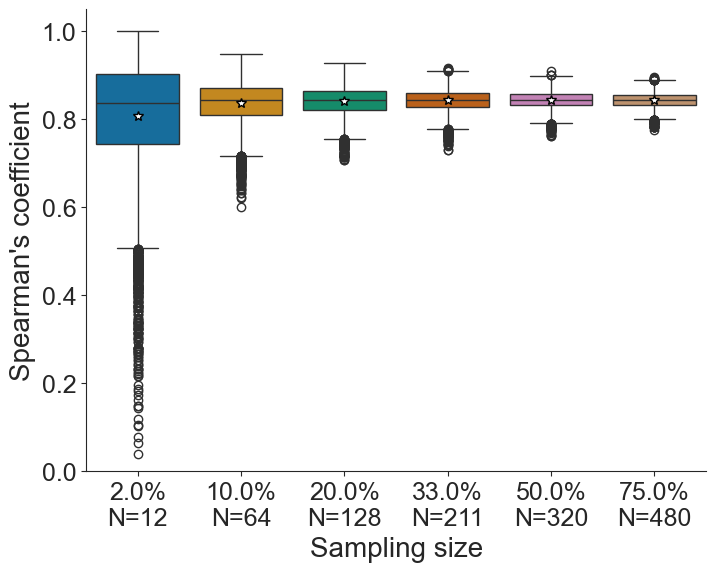

In [6]:
# Plot bootstrap 
nb_column_perf = 2 #pearson, pearson_p, spearman, spearman_p, rmse, std_ratio
name_perf = 'Spearman\'s coefficient' 

sns.set_style('white', {'axes.spines.right':False, 'axes.spines.top': False,
                    'xtick.bottom': True, 'ytick.left': True})
plt.figure(figsize=(8,6))

colors=sns.color_palette("colorblind")


data, sizes = list(), list()
for size, perf_by_size in performance_distributions.items():
    metric = [perf[nb_column_perf] for perf in perf_by_size]
    data.extend(metric)
    sizes.extend([f'{round(size * 100, 1)}%\nN={int(size * len(all_pred))}'] * len(metric))
    print(size, ' median ', np.median(metric))
    print(size, ' mean ', np.mean(metric))
    print(size, ' quantile 0.25 ', np.quantile(metric, 0.25))
    print(size, ' quantile 0.75 ', np.quantile(metric, 0.75))
    print(size, ' lower whisk ', np.quantile(metric, 0.25) - (np.quantile(metric, 0.75)-np.quantile(metric, 0.25))*1.5)


sns.boxplot(x=sizes, y=data, palette="colorblind", showmeans=True,
            meanprops={"marker":"*","markerfacecolor":"white", "markeredgecolor":"black", "markersize":"7"})

plt.xlabel('Sampling size', fontsize=20)
plt.ylabel(name_perf, fontsize=20)
plt.legend(loc='upper left', markerscale=2, ncol=1, fontsize=20,frameon=False, framealpha=0.4, handletextpad=0.2, columnspacing=1.0)


# plt.title(f"{n_bootstraps}-boostratping", fontsize=25, y=1.02)
plt.tick_params(bottom=True, left=True, labelsize=18)
plt.ylim(0,1.05)
plt.savefig(os.path.join(folder_figures, 'figureS10b.png'), dpi=800, bbox_inches='tight', transparent=True)
plt.show()
plt.close()



0.02  median  0.875
0.02  mean  0.847217603
0.02  quantile 0.25  0.798
0.02  quantile 0.75  0.926
0.02  lower whisk  0.6060000000000001
0.1  median  0.867
0.1  mean  0.8612425899999999
0.1  quantile 0.25  0.836
0.1  quantile 0.75  0.892
0.1  lower whisk  0.7519999999999999
0.2  median  0.866
0.2  mean  0.86295126
0.2  quantile 0.25  0.844
0.2  quantile 0.75  0.884
0.2  lower whisk  0.7839999999999999
0.33  median  0.865
0.33  mean  0.86371682
0.33  quantile 0.25  0.849
0.33  quantile 0.75  0.88
0.33  lower whisk  0.8025
0.5  median  0.865
0.5  mean  0.8640755400000002
0.5  quantile 0.25  0.852
0.5  quantile 0.75  0.877
0.5  lower whisk  0.8145
0.75  median  0.865
0.75  mean  0.8643406400000001
0.75  quantile 0.25  0.855
0.75  quantile 0.75  0.875
0.75  lower whisk  0.825


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 800x600 with 0 Axes>

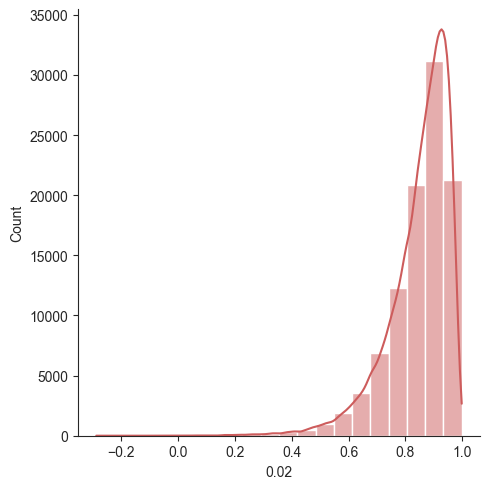

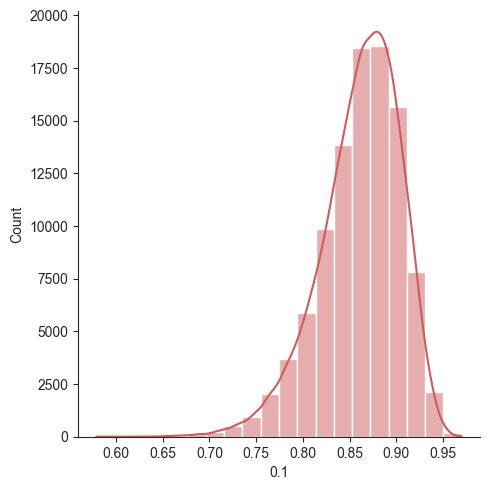

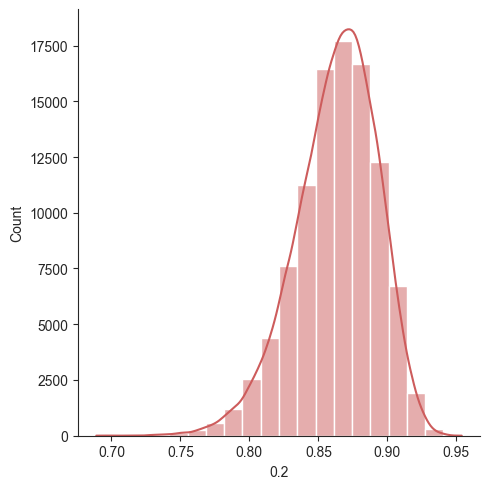

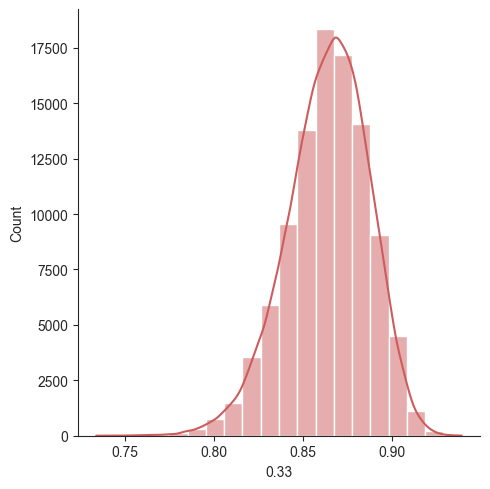

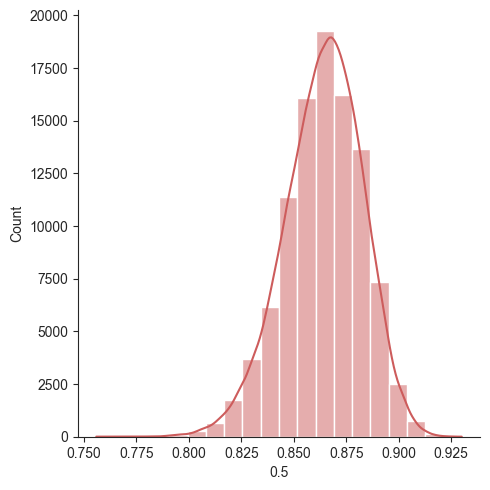

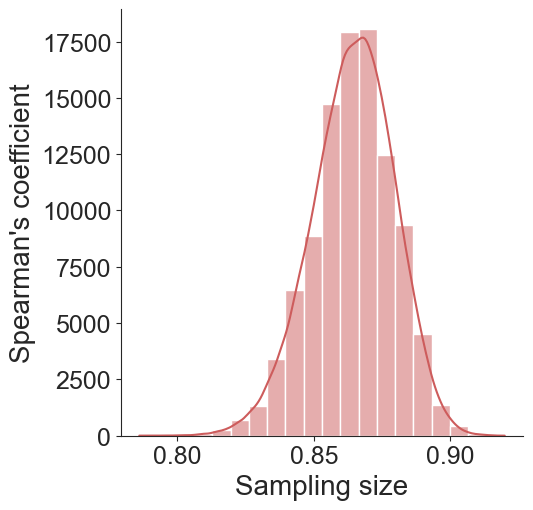

In [37]:
# Plot bootstrap 
nb_column_perf = 0 #pearson, pearson_p, spearman, spearman_p, rmse, std_ratio
name_perf = 'Spearman\'s coefficient' 

sns.set_style('white', {'axes.spines.right':False, 'axes.spines.top': False,
                    'xtick.bottom': True, 'ytick.left': True})
plt.figure(figsize=(8,6))

colors=sns.color_palette("colorblind")


# for k, size in enumerate(performance_distributions):
#     perf_by_size = performance_distributions[size]
#     metric = [perf[nb_column_perf] for perf in perf_by_size]
#     sns.boxplot(metric, kde=True, label=f'Size: {round(size * 100,1)}% (N={int(size * len(all_pred))})', color = colors[k], stat="density", common_norm=False)

data, sizes = list(), list()
for size, perf_by_size in performance_distributions.items():
    metric = [perf[nb_column_perf] for perf in perf_by_size]
    data.extend(metric)
    sizes.extend([f'{round(size * 100, 1)}%\nN={int(size * len(all_pred))}'] * len(metric))
    print(size, ' median ', np.median(metric))
    print(size, ' mean ', np.mean(metric))
    print(size, ' quantile 0.25 ', np.quantile(metric, 0.25))
    print(size, ' quantile 0.75 ', np.quantile(metric, 0.75))
    print(size, ' lower whisk ', np.quantile(metric, 0.25) - (np.quantile(metric, 0.75)-np.quantile(metric, 0.25))*1.5)

    sns.displot({size: metric}, x=size, bins=20, kde=True, color='indianred')


plt.xlabel('Sampling size', fontsize=20)
plt.ylabel(name_perf, fontsize=20)
plt.legend(loc='upper left', markerscale=2, ncol=1, fontsize=20,frameon=False, framealpha=0.4, handletextpad=0.2, columnspacing=1.0)


# plt.title(f"{n_bootstraps}-boostratping", fontsize=25, y=1.02)
plt.tick_params(bottom=True, left=True, labelsize=18)
plt.savefig(os.path.join(folder_figures, 'boostrapping.png'), dpi=800, bbox_inches='tight', transparent=True)
plt.show()
plt.close()

